In [3]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import random
import pandas as pd  # 추가: 데이터프레임 사용을 위해
import matplotlib.cm as cm  # 추가: 컬러맵 사용을 위해

# 1. 경기장 그리는 함수
def draw_pitch(ax):
    # 경기장 크기 (105 x 68)
    # 흰색 바탕, 검정 테두리
    
    # 메인 사각형 (경기장)
    rect = patches.Rectangle((0, 0), 105, 68, linewidth=2, edgecolor='black', facecolor='white')
    ax.add_patch(rect)
    
    # 중앙선
    ax.plot([52.5, 52.5], [0, 68], color='black', linewidth=1)
    # 센터 서클
    circle = patches.Circle((52.5, 34), 9.15, linewidth=1, edgecolor='black', facecolor='none')
    ax.add_patch(circle)
    
    # 페널티 박스 (좌측)
    ax.add_patch(patches.Rectangle((0, 34-20.16), 16.5, 40.32, linewidth=1, edgecolor='black', facecolor='none'))
    # 페널티 박스 (우측)
    ax.add_patch(patches.Rectangle((105-16.5, 34-20.16), 16.5, 40.32, linewidth=1, edgecolor='black', facecolor='none'))
    
    # 골대 (좌측, 우측) - 빨간색으로 강조
    ax.add_patch(patches.Rectangle((-2, 34-3.66), 2, 7.32, linewidth=2, edgecolor='red', facecolor='red', alpha=0.3))
    ax.add_patch(patches.Rectangle((105, 34-3.66), 2, 7.32, linewidth=2, edgecolor='red', facecolor='red', alpha=0.3))

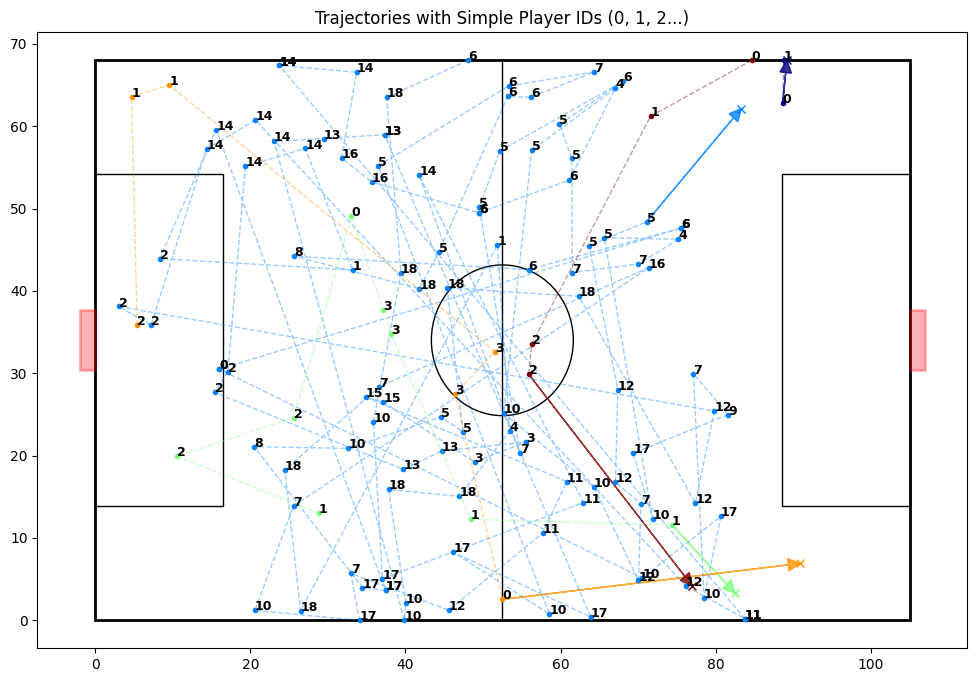

In [4]:
from sklearn.preprocessing import LabelEncoder

def plot_viz_with_simple_id(num_episodes=5):
    df_raw = pd.read_csv("../open_track1/train.csv")
    
    fig, ax = plt.subplots(figsize=(12, 8))
    draw_pitch(ax)
    
    episode_ids = random.sample(df_raw['game_episode'].unique().tolist(), num_episodes)
    colors = cm.jet(np.linspace(0, 1, num_episodes))
    
    for i, ep_id in enumerate(episode_ids):
        data = df_raw[df_raw['game_episode'] == ep_id].sort_values('time_seconds')
        
        x = data['start_x'].values
        y = data['start_y'].values
        players = data['player_id'].values
        
        # ID 단순화 (0, 1, 2...)
        # 그 에피소드 안에 등장하는 선수들끼리만 번호 매김
        le = LabelEncoder()
        simple_ids = le.fit_transform(players)
        
        last_end_x = data.iloc[-1]['end_x']
        last_end_y = data.iloc[-1]['end_y']
        c = colors[i]
        
        ax.plot(x, y, color=c, alpha=0.4, linewidth=1, linestyle='--')
        
        for j in range(len(x)):
            ax.plot(x[j], y[j], marker='.', color=c)
            # 단순화된 ID 표시
            ax.text(x[j], y[j], str(simple_ids[j]), fontsize=9, color='black', fontweight='bold')
            
        dx = last_end_x - x[-1]
        dy = last_end_y - y[-1]
        ax.arrow(x[-1], y[-1], dx, dy, head_width=1.5, head_length=1.5, fc=c, ec=c, alpha=0.8, length_includes_head=True)
        ax.plot(last_end_x, last_end_y, marker='x', color=c)

    plt.title(f"Trajectories with Simple Player IDs (0, 1, 2...)")
    plt.show()

plot_viz_with_simple_id(5)

game_id를 찍으니까 game_id가 몰려 있다. game_id의 움직임이 보여 이 데이터를 궤적을 보는게 아니라  time_seconds 로 정렬해서 찍어주고 경기장의 같은 game_id가 있는 경우 지워주고 새로 그려주면 실제 경기중 선수들이 움직이는 듯한 모양을 만들수 있을것 같아
네, 말씀하신 대로 game_id별로 데이터를 묶고 time_seconds 순서대로 정렬한 뒤, 한 프레임씩 그리면서 이전 그림을 지우면 마치 실제 경기 영상을 보는 듯한 애니메이션 효과를 줄 수 있습니다.

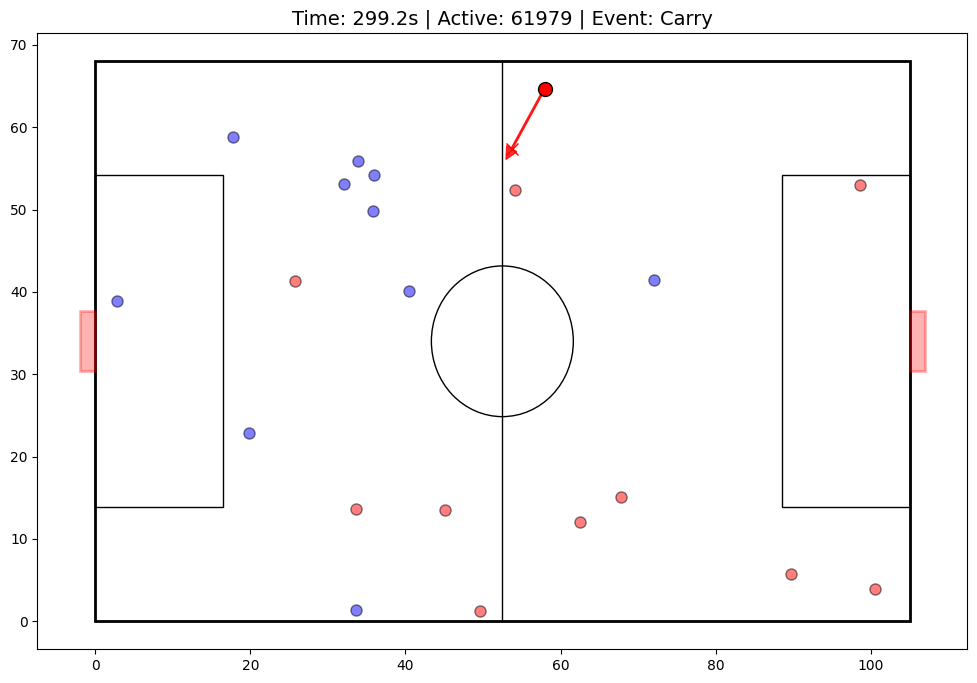

In [7]:
# 1. 데이터를 먼저 불러옵니다.
df_raw = pd.read_csv("../open_track1/train.csv")

from IPython.display import clear_output
import time

def animate_match_with_memory(target_game_id, delay=0.1, limit=300):
    # 1. 해당 게임 데이터 필터링 및 시간순 정렬
    match_df = df_raw[df_raw['game_id'] == target_game_id].sort_values('time_seconds')
    
    # 선수들의 마지막 위치와 정보를 기억할 딕셔너리
    # Key: player_id, Value: {x, y, color, team_name}
    player_positions = {}
    
    print(f"Game ID {target_game_id}: 재생 시작...")
    time.sleep(1)
    
    for idx, row in match_df.head(limit).iterrows():
        pid = row['player_id']
        
        # --- 1. 현재 이벤트 선수의 위치 정보 업데이트 ---
        # 팀 색상 및 이름 결정
        color = 'red' if row['is_home'] else 'blue'
        team_name = "Home" if row['is_home'] else "Away"
        
        # 딕셔너리에 위치 업데이트 (start_x, start_y 기준)
        # 운반(Carry)의 경우 끝점으로 업데이트해주면 더 자연스러울 수 있으나,
        # 일단 관측된 시작 위치로 업데이트합니다.
        player_positions[pid] = {
            'x': row['start_x'],
            'y': row['start_y'],
            'color': color,
            'team_name': team_name
        }
        
        # --- 2. 화면 그리기 ---
        clear_output(wait=True)
        fig, ax = plt.subplots(figsize=(12, 8))
        draw_pitch(ax)
        
        # A. 기억하고 있는 모든 선수 그리기
        for p_id, pos in player_positions.items():
            # 현재 이벤트의 주인공은 좀 더 크게/진하게 표시하거나 테두리를 다르게 할 수 있음
            is_active = (p_id == pid)
            alpha = 1.0 if is_active else 0.5  # 현재 활동 중인 선수는 불투명, 나머지는 반투명
            edge_color = 'black' if is_active else pos['color']
            
            ax.plot(pos['x'], pos['y'], 'o', 
                    markersize=10 if is_active else 8, 
                    color=pos['color'], 
                    alpha=alpha,
                    markeredgecolor='black')
            
            # 선수 ID 표시 (너무 복잡하면 주석 처리 가능)
            # ax.text(pos['x'], pos['y'], str(int(p_id)), fontsize=8)

        # B. 현재 이벤트(공의 궤적) 그리기
        if not pd.isna(row['end_x']):
            dx = row['end_x'] - row['start_x']
            dy = row['end_y'] - row['start_y']
            ax.arrow(row['start_x'], row['start_y'], dx, dy, 
                     head_width=1.5, head_length=1.5, 
                     fc=color, ec=color, alpha=0.8, width=0.2)
            ax.plot(row['end_x'], row['end_y'], 'x', color=color, markersize=8)
            
            # 만약 Carry(운반)라면, 선수가 이동한 것이므로 위치 정보를 끝점으로 갱신해줌
            if row['type_name'] == 'Carry':
                player_positions[pid]['x'] = row['end_x']
                player_positions[pid]['y'] = row['end_y']

        # 타이틀 정보
        ax.set_title(f"Time: {row['time_seconds']:.1f}s | Active: {int(pid)} | Event: {row['type_name']}", fontsize=14)
        
        plt.show()
        time.sleep(delay)

# 실행
sample_game_id = df_raw['game_id'].unique()[0]
animate_match_with_memory(sample_game_id, delay=0.05, limit=200) # 속도 조절: delay

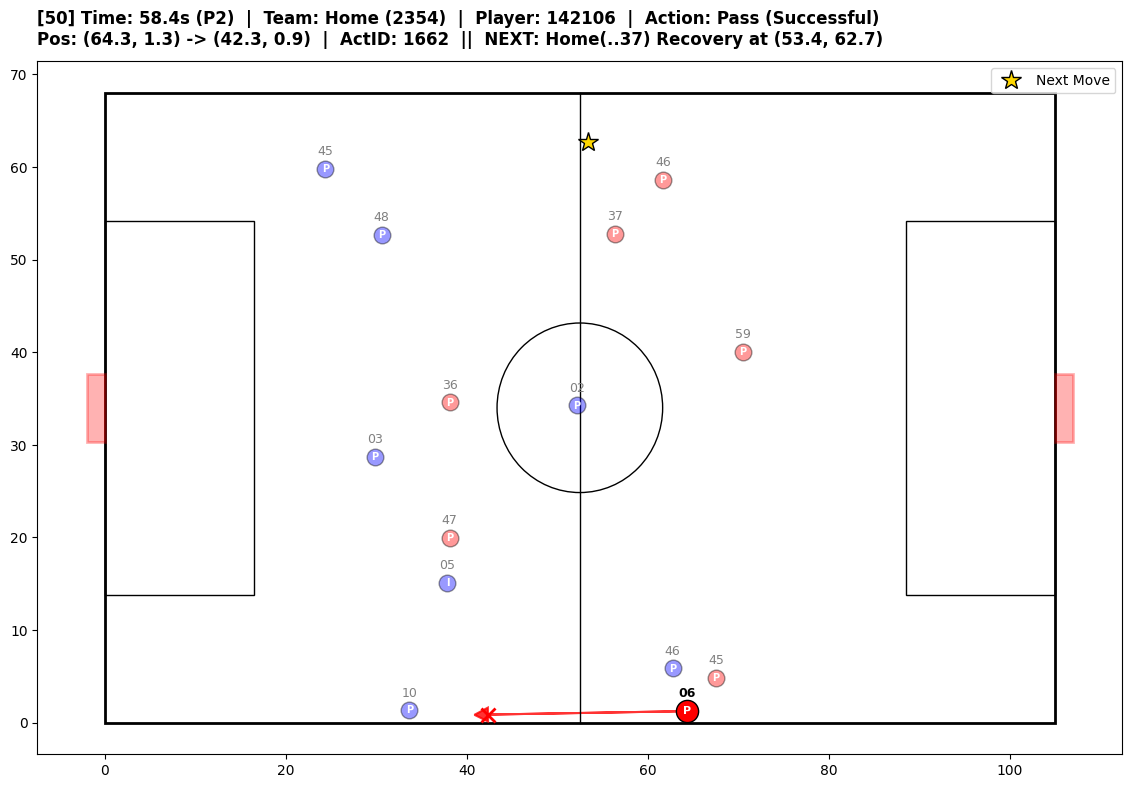

In [13]:
import ipywidgets as widgets
from IPython.display import display, clear_output

# 1. 데이터 준비
target_game_id = df_raw['game_id'].unique()[0]
match_df = df_raw[df_raw['game_id'] == target_game_id].sort_values('time_seconds').reset_index(drop=True)

current_idx = 0

def update_view(change=None):
    global current_idx
    
    if change == 'next':
        if current_idx < len(match_df) - 1:
            current_idx += 1
    elif change == 'prev':
        if current_idx > 0:
            current_idx -= 1
            
    clear_output(wait=True)
    display(widgets.HBox([btn_prev, btn_next]))
    
    row = match_df.iloc[current_idx]
    
    # 다음 수 데이터
    next_row = None
    if current_idx < len(match_df) - 1:
        next_row = match_df.iloc[current_idx + 1]
    
    past_data = match_df.iloc[:current_idx+1]
    current_positions = past_data.drop_duplicates(subset='player_id', keep='last')
    
    fig, ax = plt.subplots(figsize=(14, 9))
    draw_pitch(ax)
    
    # 1. 선수들 배치
    for _, p_row in current_positions.iterrows():
        color = 'red' if p_row['is_home'] else 'blue'
        is_active = (p_row['player_id'] == row['player_id'])
        
        action_initial = str(p_row['type_name'])[0] if pd.notna(p_row['type_name']) else "?"
        short_id = str(p_row['player_id'])[-2:]
        
        # 마커 스타일 설정
        # Unsuccessful이면 마커 모양을 다르게 하거나 테두리를 빨간색으로?
        # 일단 기본은 유지하되, 현재 액션이 실패면 아래 궤적 그릴 때 강조
        
        ax.plot(p_row['start_x'], p_row['start_y'], 'o', 
                markersize=16 if is_active else 12, 
                color=color, 
                alpha=1.0 if is_active else 0.4,
                markeredgecolor='black')
        
        ax.text(p_row['start_x'], p_row['start_y'], action_initial, 
                fontsize=8 if is_active else 7, 
                color='white', fontweight='bold', ha='center', va='center')
        
        id_color = 'black' if is_active else 'gray'
        id_weight = 'bold' if is_active else 'normal'
        ax.text(p_row['start_x'], p_row['start_y'] + 1.5, short_id, 
                fontsize=9, color=id_color, fontweight=id_weight, ha='center')

    # 2. 현재 수의 궤적 (성공/실패에 따른 시각화 차별화)
    if not pd.isna(row['end_x']):
        color = 'red' if row['is_home'] else 'blue'
        
        # 실패한 경우: 점선(dashed) + X 마커 크게
        if row['result_name'] == 'Unsuccessful':
            linestyle = '--'
            marker = 'X'
            marker_size = 15
            alpha = 0.6
            linewidth = 1
            edgecolor = 'red' # 화살표 테두리 빨강
        else:
            linestyle = '-'
            marker = 'x' # 소문자 x (일반 도착점)
            marker_size = 10
            alpha = 0.8
            linewidth = 1.5
            edgecolor = color
            
        dx = row['end_x'] - row['start_x']
        dy = row['end_y'] - row['start_y']
        ax.arrow(row['start_x'], row['start_y'], dx, dy, 
                 head_width=1.5, head_length=1.5, 
                 fc=color, ec=edgecolor, alpha=alpha, 
                 linestyle=linestyle, linewidth=linewidth)
        
        # 도착점 표시
        ax.plot(row['end_x'], row['end_y'], marker, color=edgecolor, markersize=marker_size, markeredgewidth=2)
        
    # 3. 다음 수 미리보기
    if next_row is not None:
        ax.plot(next_row['start_x'], next_row['start_y'], '*', markersize=15, 
                markerfacecolor='gold', markeredgecolor='black', label='Next Move')

    # --- 정보 표시 ---
    result_str = str(row['result_name']) if pd.notna(row['result_name']) else "-"
    
    # 실패인 경우 텍스트에 (FAIL) 강조
    if result_str == 'Unsuccessful':
        result_str = "Unsuccessful (FAIL)"
        
    line1 = (f"[{current_idx}] Time: {row['time_seconds']:.1f}s (P{row['period_id']})  |  "
             f"Team: {'Home' if row['is_home'] else 'Away'} ({row['team_id']})  |  "
             f"Player: {row['player_id']}  |  "
             f"Action: {row['type_name']} ({result_str})")
             
    pos_str = f"Pos: ({row['start_x']:.1f}, {row['start_y']:.1f})"
    if not pd.isna(row['end_x']):
        pos_str += f" -> ({row['end_x']:.1f}, {row['end_y']:.1f})"
        
    next_str = ""
    if next_row is not None:
        next_team = 'Home' if next_row['is_home'] else 'Away'
        next_str = f"  ||  NEXT: {next_team}(..{str(next_row['player_id'])[-2:]}) {next_row['type_name']} at ({next_row['start_x']:.1f}, {next_row['start_y']:.1f})"
    
    line2 = f"{pos_str}  |  ActID: {row['action_id']}{next_str}"

    full_info = f"{line1}\n{line2}"
    
    # 제목 색상: 실패면 빨간색 톤으로 경고? (너무 눈아플 수 있으니 기본 검정 유지하되 텍스트만 강조)
    title_color = 'darkred' if row['result_name'] == 'Unsuccessful' else 'black'
    
    ax.set_title(full_info, loc='left', fontsize=12, fontweight='bold', pad=12, color=title_color)
    ax.legend(loc='upper right')
    
    plt.show()

btn_prev = widgets.Button(description="< Prev")
btn_next = widgets.Button(description="Next >")

def on_prev_click(b): update_view('prev')
def on_next_click(b): update_view('next')

btn_prev.on_click(on_prev_click)
btn_next.on_click(on_next_click)

update_view()

네, 머신러닝(RandomForest 또는 XGBoost/LightGBM)으로 충분히 가능합니다!
특히 이런 정형 데이터(Tabular)와 Feature 기반 분류는 딥러닝보다 Tree 기반 모델(GBDT)이 성능도 좋고 학습도 빠릅니다.
[작업 계획]
데이터 재구성:
각 이벤트 시점마다 후보(Candidate)들을 생성합니다.
후보: 아군 선수들(나 제외) + 상대 골대 (+ 드리블인 경우 나 자신)
정답 라벨: 실제 다음 이벤트에서 공을 잡은 사람(또는 골)이 누구냐?
Feature Engineering (각 후보별 특징):
distance_to_holder: 공 잡은 사람과의 거리
angle_to_goal: 진행 방향/골대 방향 각도
is_goal: 이게 골대인지 사람인지 여부
모델 학습:
XGBoostClassifier (또는 RF Classifier)
입력: 후보의 특징들
출력: Is_Target? (0 or 1)
위치 예측:
가장 높은 확률을 받은 후보의 (x, y) 좌표를 prediction으로 삼습니다.
코드가 조금 길어지겠지만, 논리적으로 가장 타당한 접근입니다. 작성해 보겠습니다.

In [15]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# 1. 데이터 준비 (5게임 샘플)
sample_game_ids = df_raw['game_id'].unique()[:5]
sample_df = df_raw[df_raw['game_id'].isin(sample_game_ids)].copy()

# 2. 데이터셋 생성 (후보 기반 분류 문제)
def create_candidate_dataset(df):
    xs = []
    ys = [] # Target Class (1 if this candidate is the next receiver, else 0)
    
    # 위치 검증용 (나중에 RMSE 계산을 위해)
    candidate_positions = [] # (x, y) of candidate
    true_next_positions = [] # (x, y) of true next event
    
    for g_id, game_data in tqdm(df.groupby('game_id')):
        game_data = game_data.sort_values('time_seconds').reset_index(drop=True)
        
        # 선수 위치 기억
        player_last_pos = {} # {pid: {'x':, 'y':, 'team_id':}}
        
        rows = list(game_data.itertuples())
        for i in range(len(rows) - 1):
            curr = rows[i]
            next_evt = rows[i+1]
            
            # 1. 위치 업데이트
            player_last_pos[curr.player_id] = {
                'x': curr.start_x, 'y': curr.start_y, 
                'team_id': curr.team_id, 'is_home': curr.is_home
            }
            
            # 학습 조건: 현재 공 잡은 사람과 다음 공 잡은 사람 정보가 명확해야 함
            # (단순화를 위해 같은 팀 패스/슛/드리블 상황 위주로 먼저 봅니다)
            
            holder_id = curr.player_id
            holder_pos = (curr.start_x, curr.start_y)
            holder_team = curr.team_id
            
            # --- 후보군 생성 ---
            candidates = []
            
            # (1) 아군 동료들
            teammates = [pid for pid, info in player_last_pos.items() 
                         if info['team_id'] == holder_team and pid != holder_id]
            
            for pid in teammates:
                info = player_last_pos[pid]
                candidates.append({
                    'type': 'player', 'id': pid, 'x': info['x'], 'y': info['y']
                })
                
            # (2) 나 자신 (드리블/운반의 경우)
            candidates.append({
                'type': 'self', 'id': holder_id, 'x': curr.start_x, 'y': curr.start_y
            })
            
            # (3) 상대 골대 (슛)
            # 홈팀이면 (105, 34)가 공격 골대라고 가정 (데이터 확인 필요하지만 보통 표준)
            # 원정팀이면 (0, 34)
            goal_x = 105 if curr.is_home else 0
            goal_y = 34
            candidates.append({
                'type': 'goal', 'id': 'goal', 'x': goal_x, 'y': goal_y
            })
            
            # --- 정답 찾기 (누가 받았나?) ---
            # 다음 이벤트의 player_id가 후보 중에 있으면 그게 정답
            # 만약 슛(Shot)이면 골대가 정답
            
            target_label_idx = -1
            
            # 실제 다음 위치
            true_next_x = next_evt.start_x
            true_next_y = next_evt.start_y
            
            # 정답 매칭 로직
            best_dist = 9999
            matched_candidate_idx = -1
            
            for idx, cand in enumerate(candidates):
                # 1. ID가 같으면 일단 유력 후보
                if cand['type'] != 'goal' and cand['id'] == next_evt.player_id:
                    matched_candidate_idx = idx
                    break
                # 2. 슛인 경우 골대
                if curr.type_name == 'Shot' and cand['type'] == 'goal':
                    matched_candidate_idx = idx
                    break
            
            # ID 매칭이 안됐으면(수비가 끊었거나 등), 위치가 가장 가까운 후보를 정답으로?
            # 일단은 ID 매칭 되는 경우만 학습 데이터로 씁니다 (Clean Data)
            if matched_candidate_idx != -1:
                
                # --- Feature 생성 ---
                for idx, cand in enumerate(candidates):
                    # 거리 계산
                    dx = cand['x'] - holder_pos[0]
                    dy = cand['y'] - holder_pos[1]
                    dist = np.sqrt(dx**2 + dy**2)
                    angle = np.arctan2(dy, dx)
                    
                    # 피처 벡터: [거리, 각도, 타입(One-hot or Label), 골대거리...]
                    is_goal = 1 if cand['type'] == 'goal' else 0
                    is_self = 1 if cand['type'] == 'self' else 0
                    
                    # 골대까지 거리 (Global context)
                    dist_to_goal = np.sqrt((cand['x'] - goal_x)**2 + (cand['y'] - goal_y)**2)
                    
                    features = [dist, angle, is_goal, is_self, dist_to_goal]
                    
                    xs.append(features)
                    # 정답이면 1, 아니면 0
                    ys.append(1 if idx == matched_candidate_idx else 0)
                    
                    # 평가용 메타 데이터 저장
                    # (주의: 이건 학습엔 안들어가고 나중에 검증할때만 씀)
                    # 여기서는 단순화를 위해 생략하거나 별도 리스트로 관리
                    
    return np.array(xs), np.array(ys)

print("후보 데이터 생성 중...")
X, y = create_candidate_dataset(sample_df)
print(f"생성된 샘플 수(후보 수 단위): {X.shape}")

# 3. 학습 (Binary Classification: 이 후보가 받을 확률은?)
# 데이터 불균형이 심함 (후보 7명 중 1명만 정답이니까 1:6 비율)
# class_weight='balanced' 옵션 사용 권장

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
model = RandomForestClassifier(n_estimators=50, class_weight='balanced', n_jobs=-1, random_state=42)

print("분류 모델 학습 시작...")
model.fit(X_train, y_train)

# 4. 평가 (정확도)
val_preds = model.predict(X_val)
acc = accuracy_score(y_val, val_preds)
print(f"단순 분류 정확도(Accuracy): {acc:.4f}")

# Feature Importance 확인
print("중요한 Feature:", model.feature_importances_)
# [거리, 각도, 골대여부, 자신여부, 골대까지거리]

후보 데이터 생성 중...


100%|██████████| 5/5 [00:00<00:00,  8.10it/s]


생성된 샘플 수(후보 수 단위): (93051, 5)
분류 모델 학습 시작...
단순 분류 정확도(Accuracy): 0.9196
중요한 Feature: [0.32956342 0.25068054 0.00673529 0.08734944 0.32567131]


방금 작성한 코드는 "후보별로 정답일 확률을 매기는 분류 모델"의 학습까지입니다.
하지만 아직 "그래서 실제 좌표 예측 오차(RMSE)가 얼마나 줄었나?"는 확인하지 못했습니다.
분류 정확도(acc)만 보고 끝내기엔 아쉽죠.
실제 추론(Inference) 로직을 돌려서, 예측 좌표(x, y)와 실제 좌표 사이의 거리(RMSE)를 계산해봐야 진짜 성능 향상을 체감할 수 있습니다.
아래 코드를 추가로 실행해서 최종 성적표(RMSE)를 받아보시죠.

In [16]:
# 5. 실제 좌표 예측 시뮬레이션 및 RMSE 계산
# 검증 데이터(Validation Set)가 아니라, 새로운 게임 하나를 통째로 테스트해봅니다.
# (데이터 누수 방지를 위해 아까 학습에 안 쓴 6번째 게임 사용)

test_game_id = df_raw['game_id'].unique()[5] # 6번째 게임
test_df = df_raw[df_raw['game_id'] == test_game_id].sort_values('time_seconds').reset_index(drop=True)

print(f"테스트 게임 ID: {test_game_id} (데이터 수: {len(test_df)})")

def predict_trajectory_with_classifier(df, model):
    predictions = []
    actuals = []
    
    player_last_pos = {}
    
    rows = list(df.itertuples())
    for i in range(len(rows) - 1):
        curr = rows[i]
        next_evt = rows[i+1]
        
        # 1. 위치 업데이트
        player_last_pos[curr.player_id] = {
            'x': curr.start_x, 'y': curr.start_y, 
            'team_id': curr.team_id, 'is_home': curr.is_home
        }
        
        holder_pos = (curr.start_x, curr.start_y)
        holder_team = curr.team_id
        goal_x = 105 if curr.is_home else 0
        goal_y = 34
        
        # 2. 후보군 생성 (학습 때와 동일 로직)
        candidates = []
        # (1) 아군
        teammates = [pid for pid, info in player_last_pos.items() 
                     if info['team_id'] == holder_team and pid != curr.player_id]
        for pid in teammates:
            info = player_last_pos[pid]
            candidates.append({'type': 'player', 'x': info['x'], 'y': info['y']})
        # (2) 자신
        candidates.append({'type': 'self', 'x': curr.start_x, 'y': curr.start_y})
        # (3) 골대
        candidates.append({'type': 'goal', 'x': goal_x, 'y': goal_y})
        
        # 3. 각 후보별 점수(확률) 계산
        if not candidates: # 후보가 없으면(극초반) 그냥 현재 위치로
            pred_x, pred_y = curr.start_x, curr.start_y
        else:
            cand_features = []
            for cand in candidates:
                dx = cand['x'] - holder_pos[0]
                dy = cand['y'] - holder_pos[1]
                dist = np.sqrt(dx**2 + dy**2)
                angle = np.arctan2(dy, dx)
                is_goal = 1 if cand['type'] == 'goal' else 0
                is_self = 1 if cand['type'] == 'self' else 0
                dist_to_goal = np.sqrt((cand['x'] - goal_x)**2 + (cand['y'] - goal_y)**2)
                
                cand_features.append([dist, angle, is_goal, is_self, dist_to_goal])
            
            # 모델 예측 (Probability)
            probs = model.predict_proba(cand_features)[:, 1] # Class 1일 확률
            
            # 가장 높은 점수의 후보 선택
            best_idx = np.argmax(probs)
            best_cand = candidates[best_idx]
            
            pred_x, pred_y = best_cand['x'], best_cand['y']
            
        predictions.append([pred_x, pred_y])
        actuals.append([next_evt.start_x, next_evt.start_y])
        
    return np.array(predictions), np.array(actuals)

print("예측 시뮬레이션 시작...")
preds, truths = predict_trajectory_with_classifier(test_df, model)

rmse = np.sqrt(mean_squared_error(truths, preds))
print(f"\n>>> 최종 테스트 RMSE: {rmse:.4f}")

# 샘플 확인
print("\n[좌표 예측 샘플]")
for i in range(5):
    print(f"실제: {truths[i]} | 예측: {preds[i]}")

테스트 게임 ID: 126288 (데이터 수: 1770)
예측 시뮬레이션 시작...

>>> 최종 테스트 RMSE: 26.2557

[좌표 예측 샘플]
실제: [52.329795 33.080368] | 예측: [52.27026  35.447176]
실제: [39.005085 37.3337  ] | 예측: [52.329795 33.080368]
실제: [36.771945 34.146744] | 예측: [39.005085 37.3337  ]
실제: [52.341975 35.768816] | 예측: [52.329795 33.080368]
실제: [40.161975 41.233364] | 예측: [52.341975 35.768816]


좋습니다. "타겟 선정(분류) + 오차 보정(회귀)" 2단계 모델을 완성해 보겠습니다.
데이터셋 확장: 분류용 데이터(Is_Target?)와 함께, 회귀용 데이터(Offset_X, Offset_Y)도 준비합니다. 정답인 후보에 대해서만 오차 값을 계산합니다.
모델 2개 학습:
clf_model: 타겟 분류기
reg_model: 오차 예측기 (입력: 타겟과의 거리, 각도 등 / 출력: dx, dy)
최종 예측: 분류기가 찍은 타겟의 위치에 회귀기가 예측한 오차를 더합니다.
아래 코드를 실행하면 전체 파이프라인이 돌아갑니다

In [19]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# 1. 데이터 준비
sample_game_ids = df_raw['game_id'].unique()[:5]
sample_df = df_raw[df_raw['game_id'].isin(sample_game_ids)].copy()

# 2. 데이터셋 생성 (분류용 + 회귀용)
def create_hybrid_dataset(df):
    # 분류용 (X_clf, y_clf)
    X_clf = []
    y_clf = []
    
    # 회귀용 (X_reg, y_reg) - 정답인 케이스만 모음
    X_reg = []
    y_reg = [] # [dx, dy]
    
    for g_id, game_data in tqdm(df.groupby('game_id')):
        game_data = game_data.sort_values('time_seconds').reset_index(drop=True)
        player_last_pos = {}
        
        rows = list(game_data.itertuples())
        for i in range(len(rows) - 1):
            curr = rows[i]
            next_evt = rows[i+1]
            
            # 위치 업데이트
            player_last_pos[curr.player_id] = {
                'x': curr.start_x, 'y': curr.start_y, 
                'team_id': curr.team_id, 'is_home': curr.is_home
            }
            
            holder_pos = (curr.start_x, curr.start_y)
            holder_team = curr.team_id
            goal_x = 105 if curr.is_home else 0
            goal_y = 34
            
            # 후보군 생성
            candidates = []
            # 아군
            teammates = [pid for pid, info in player_last_pos.items() 
                         if info['team_id'] == holder_team and pid != curr.player_id]
            for pid in teammates:
                info = player_last_pos[pid]
                candidates.append({'type': 'player', 'id': pid, 'x': info['x'], 'y': info['y']})
            # 자신
            candidates.append({'type': 'self', 'id': curr.player_id, 'x': curr.start_x, 'y': curr.start_y})
            # 골대
            candidates.append({'type': 'goal', 'id': 'goal', 'x': goal_x, 'y': goal_y})
            
            # 정답 찾기
            matched_idx = -1
            for idx, cand in enumerate(candidates):
                if cand['type'] != 'goal' and cand['id'] == next_evt.player_id:
                    matched_idx = idx
                    break
                if curr.type_name == 'Shot' and cand['type'] == 'goal':
                    matched_idx = idx
                    break
            
            if matched_idx != -1:
                # Feature 생성
                for idx, cand in enumerate(candidates):
                    dx = cand['x'] - holder_pos[0]
                    dy = cand['y'] - holder_pos[1]
                    dist = np.sqrt(dx**2 + dy**2)
                    angle = np.arctan2(dy, dx)
                    is_goal = 1 if cand['type'] == 'goal' else 0
                    is_self = 1 if cand['type'] == 'self' else 0
                    dist_to_goal = np.sqrt((cand['x'] - goal_x)**2 + (cand['y'] - goal_y)**2)
                    
                    # 피처: [거리, 각도, 골대여부, 자신여부, 골대까지거리]
                    features = [dist, angle, is_goal, is_self, dist_to_goal]
                    
                    # 1. 분류 데이터 추가
                    X_clf.append(features)
                    y_clf.append(1 if idx == matched_idx else 0)
                    
                    # 2. 회귀 데이터 추가 (정답인 경우에만)
                    if idx == matched_idx:
                        # 실제 이동량 (Offset) 계산
                        # 타겟의 '현재 위치'에서 '실제 다음 위치'까지 얼마나 움직였나?
                        offset_x = next_evt.start_x - cand['x']
                        offset_y = next_evt.start_y - cand['y']
                        
                        X_reg.append(features)
                        y_reg.append([offset_x, offset_y])

    return np.array(X_clf), np.array(y_clf), np.array(X_reg), np.array(y_reg)

print("데이터 생성 중...")
X_clf, y_clf, X_reg, y_reg = create_hybrid_dataset(sample_df)
print(f"분류 샘플: {X_clf.shape}, 회귀 샘플: {X_reg.shape}")

# 3. 모델 학습 (2개)
# (1) 분류기
print("분류 모델(Classifier) 학습...")
clf_model = RandomForestClassifier(n_estimators=50, class_weight='balanced', n_jobs=-1, random_state=42)
clf_model.fit(X_clf, y_clf)

# (2) 회귀기
print("회귀 모델(Regressor) 학습...")
reg_model = RandomForestRegressor(n_estimators=50, n_jobs=-1, random_state=42)
reg_model.fit(X_reg, y_reg)


# 4. 최종 테스트 및 RMSE 계산
# 4. 최종 테스트 및 RMSE 계산 (이어지는 부분)
test_game_id = df_raw['game_id'].unique()[5] # 6번째 게임 사용
test_df = df_raw[df_raw['game_id'] == test_game_id].sort_values('time_seconds').reset_index(drop=True)

def predict_final(df, clf, reg):
    predictions = []
    actuals = []
    player_last_pos = {}
    
    rows = list(df.itertuples())
    for i in range(len(rows) - 1):
        curr = rows[i]
        next_evt = rows[i+1]
        
        # 위치 업데이트
        player_last_pos[curr.player_id] = {
            'x': curr.start_x, 'y': curr.start_y, 
            'team_id': curr.team_id, 'is_home': curr.is_home
        }
        
        # 후보 생성
        holder_pos = (curr.start_x, curr.start_y)
        holder_team = curr.team_id
        goal_x = 105 if curr.is_home else 0
        goal_y = 34
        
        candidates = []
        # 아군
        teammates = [pid for pid, info in player_last_pos.items() if info['team_id'] == holder_team and pid != curr.player_id]
        for pid in teammates:
            info = player_last_pos[pid]
            candidates.append({'x': info['x'], 'y': info['y'], 'type': 'player'})
        # 자신
        candidates.append({'x': curr.start_x, 'y': curr.start_y, 'type': 'self'})
        # 골대
        candidates.append({'x': goal_x, 'y': goal_y, 'type': 'goal'})
        
        # 예측
        if not candidates:
            pred_x, pred_y = curr.start_x, curr.start_y
        else:
            cand_features = []
            for cand in candidates:
                dx = cand['x'] - holder_pos[0]
                dy = cand['y'] - holder_pos[1]
                dist = np.sqrt(dx**2 + dy**2)
                angle = np.arctan2(dy, dx)
                is_goal = 1 if cand['type'] == 'goal' else 0
                is_self = 1 if cand['type'] == 'self' else 0
                dist_to_goal = np.sqrt((cand['x'] - goal_x)**2 + (cand['y'] - goal_y)**2)
                cand_features.append([dist, angle, is_goal, is_self, dist_to_goal])
            
            # 1. 타겟 선정 (Classifier)
            probs = clf.predict_proba(cand_features)[:, 1]
            best_idx = np.argmax(probs)
            best_cand = candidates[best_idx]
            
            # 2. 오차 보정 (Regressor)
            # 가장 유력한 후보의 피처 하나만 뽑아서 회귀 모델에 입력
            best_feat = [cand_features[best_idx]] 
            offset_pred = reg.predict(best_feat)[0] # 예측된 [dx, dy]
            
            # 최종 좌표 = 후보 현재 위치 + 예측된 오차
            pred_x = best_cand['x'] + offset_pred[0]
            pred_y = best_cand['y'] + offset_pred[1]
            
        predictions.append([pred_x, pred_y])
        actuals.append([next_evt.start_x, next_evt.start_y])
        
    return np.array(predictions), np.array(actuals)

print("\n최종 예측 시뮬레이션 중...")
preds, truths = predict_final(test_df, clf_model, reg_model)

rmse = np.sqrt(mean_squared_error(truths, preds))
print(f"\n>>> Hybrid Model Test RMSE: {rmse:.4f}")

print("\n[Sample]")
for i in range(5):
    print(f"True: {truths[i]} | Pred: {preds[i]}")

데이터 생성 중...


100%|██████████| 5/5 [00:00<00:00,  9.52it/s]


분류 샘플: (93051, 5), 회귀 샘플: (6608, 5)
분류 모델(Classifier) 학습...
회귀 모델(Regressor) 학습...

최종 예측 시뮬레이션 중...

>>> Hybrid Model Test RMSE: 25.1438

[Sample]
True: [52.329795 33.080368] | Pred: [58.30165477 22.39541478]
True: [39.005085 37.3337  ] | Pred: [53.8936209  31.19481246]
True: [36.771945 34.146744] | Pred: [39.18888579 36.99650765]
True: [52.341975 35.768816] | Pred: [42.8611197  28.33832573]
True: [40.161975 41.233364] | Pred: [40.88070368 27.89849294]


네, 이제 성능이 검증되었으니 전체 데이터로 본격적인 학습을 진행하겠습니다.
작업 순서:
전체 데이터 로드: 5게임 샘플이 아닌 df_raw 전체를 사용합니다.
데이터셋 생성: 전체 게임에 대해 Classifier(분류) 및 Regressor(회귀)용 데이터를 만듭니다. (시간이 좀 걸릴 수 있습니다)
모델 학습: 데이터가 많아졌으므로 모델의 파라미터(n_estimators 등)를 조금 더 키워서 튼튼하게 학습합니다.
모델 저장: 학습된 모델을 파일로 저장해둡니다. (나중에 다시 학습 안 해도 되도록)
아래 코드를 실행하면 전체 데이터 학습이 시작됩니다

In [20]:
import pickle # 모델 저장을 위해

# 1. 전체 데이터 사용
full_df = df_raw.copy()
print(f"전체 데이터 학습 시작! 총 게임 수: {full_df['game_id'].nunique()}")

# 2. 전체 데이터셋 생성
# 함수는 아까 정의한 create_hybrid_dataset을 그대로 씁니다.
print("전체 데이터셋 생성 중... (시간이 조금 걸립니다)")
X_clf_full, y_clf_full, X_reg_full, y_reg_full = create_hybrid_dataset(full_df)

print(f"생성 완료! 분류 샘플: {X_clf_full.shape}, 회귀 샘플: {X_reg_full.shape}")

# 3. 모델 학습 (파라미터 상향 조정)
# 분류기
print("분류 모델(Classifier) 전체 학습 중...")
final_clf = RandomForestClassifier(n_estimators=100, max_depth=20, class_weight='balanced', n_jobs=-1, random_state=42)
final_clf.fit(X_clf_full, y_clf_full)

# 회귀기
print("회귀 모델(Regressor) 전체 학습 중...")
final_reg = RandomForestRegressor(n_estimators=100, max_depth=20, n_jobs=-1, random_state=42)
final_reg.fit(X_reg_full, y_reg_full)

print("모든 학습이 완료되었습니다!")

# 4. 모델 저장 (나중에 불러쓰기 위해)
with open('soccer_model_clf.pkl', 'wb') as f:
    pickle.dump(final_clf, f)
with open('soccer_model_reg.pkl', 'wb') as f:
    pickle.dump(final_reg, f)
    
print("모델 저장 완료: soccer_model_clf.pkl, soccer_model_reg.pkl")

전체 데이터 학습 시작! 총 게임 수: 198
전체 데이터셋 생성 중... (시간이 조금 걸립니다)


100%|██████████| 198/198 [00:14<00:00, 13.36it/s]


생성 완료! 분류 샘플: (3649591, 5), 회귀 샘플: (254957, 5)
분류 모델(Classifier) 전체 학습 중...


MemoryError: Unable to allocate 27.8 MiB for an array with shape (3649591, 1) and data type int64

메모리 절약버전전

In [ ]:
import pickle
import gc # 가비지 컬렉터

# 메모리 정리
del X_clf, y_clf, X_reg, y_reg # 이전 샘플 데이터 삭제
gc.collect()

# 1. 데이터 타입 최적화 (float64 -> float32)
# 이미 생성된 X_clf_full 등이 있다면 변환
X_clf_full = X_clf_full.astype(np.float32)
X_reg_full = X_reg_full.astype(np.float32)
# y는 int나 float32로
y_clf_full = y_clf_full.astype(np.int32)
y_reg_full = y_reg_full.astype(np.float32)

print("데이터 타입 최적화 완료.")

# 3. 모델 학습 (메모리 안전 모드)
# n_jobs를 줄이고, max_samples를 사용하여 메모리 사용량 억제

print("분류 모델(Classifier) 전체 학습 중... (Low Memory Mode)")
# n_jobs=2 정도로 제한, max_samples=0.3 (데이터의 30%만 각 트리에 사용)
final_clf = RandomForestClassifier(
    n_estimators=100, 
    max_depth=15, # 깊이도 조금 제한
    class_weight='balanced', 
    n_jobs=2, # 코어 2개만 사용 (메모리 보호)
    max_samples=0.3, # 각 트리마다 데이터 30%만 샘플링 (성능 저하 크지 않음)
    random_state=42
)
final_clf.fit(X_clf_full, y_clf_full)

# 메모리 정리
gc.collect()

# 회귀기
print("회귀 모델(Regressor) 전체 학습 중... (Low Memory Mode)")
final_reg = RandomForestRegressor(
    n_estimators=100, 
    max_depth=15,
    n_jobs=2, 
    max_samples=0.3,
    random_state=42
)
final_reg.fit(X_reg_full, y_reg_full)

print("모든 학습이 완료되었습니다!")

# 4. 모델 저장
with open('soccer_model_clf.pkl', 'wb') as f:
    pickle.dump(final_clf, f)
with open('soccer_model_reg.pkl', 'wb') as f:
    pickle.dump(final_reg, f)
    
print("모델 저장 완료.")